In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e4/sample_submission.csv
/kaggle/input/playground-series-s3e4/train.csv
/kaggle/input/playground-series-s3e4/test.csv
/kaggle/input/creditcardfraud/creditcard.csv


In [2]:

train=pd.read_csv('/kaggle/input/playground-series-s3e4/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s3e4/test.csv')
ss=pd.read_csv('/kaggle/input/playground-series-s3e4/sample_submission.csv')
original=pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report , average_precision_score ,precision_recall_curve

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline

from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE

import optuna
from sklearn.preprocessing import StandardScaler,RobustScaler,OrdinalEncoder,LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from matplotlib import ticker
import time
import warnings
warnings.filterwarnings('ignore')

**since The original data iis not the same of this data .. let's take only positive rows 
so that we can feed our model extra food .**

In [4]:
original=original[original['Class'] == 1]

In [5]:
train = pd.concat([original, train], axis=0)

In [6]:
train.drop(["id"] , axis = 1 , inplace = True)
test.drop(["id"] , axis = 1 , inplace = True)
TARGET = 'Class'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12 

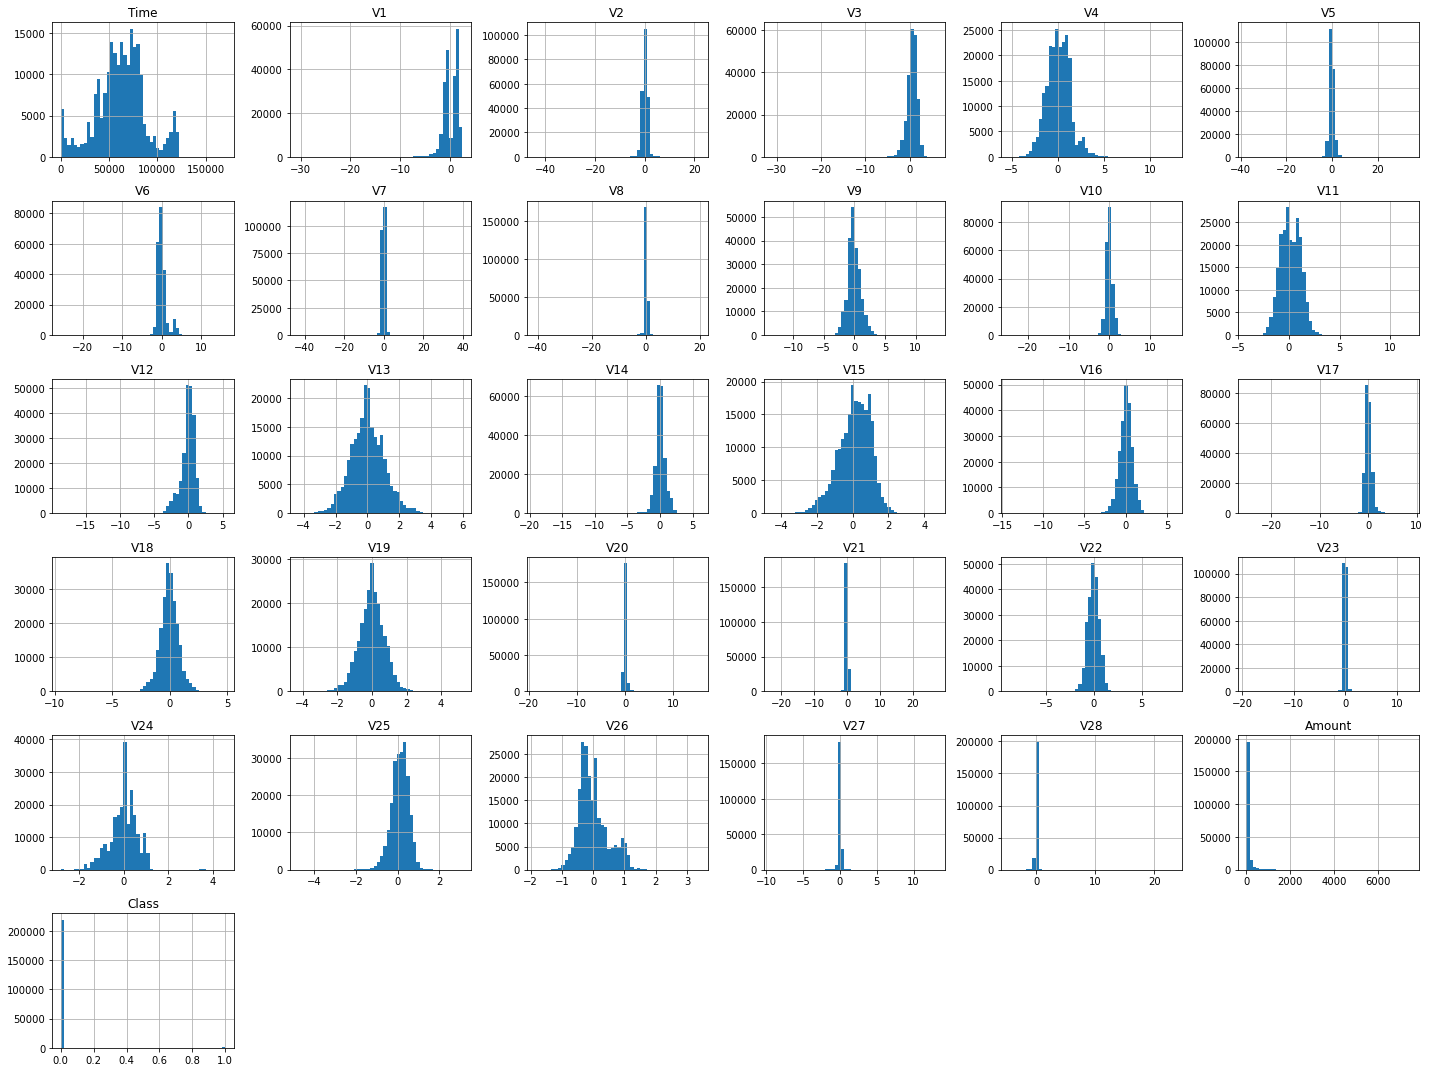

In [7]:
train.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

Look at the **Amount** .. High Skewness here 
now comes the log transformation to the rescue .

In [8]:

train['Amount'] = np.log(train['Amount'] + 1)
test['Amount'] = np.log(test['Amount'] + 1)

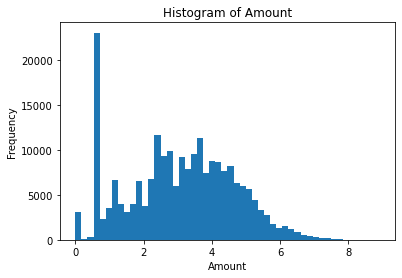

In [9]:
plt.hist(train['Amount'], bins=50)
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Amount')
plt.show()

**Looks good !**

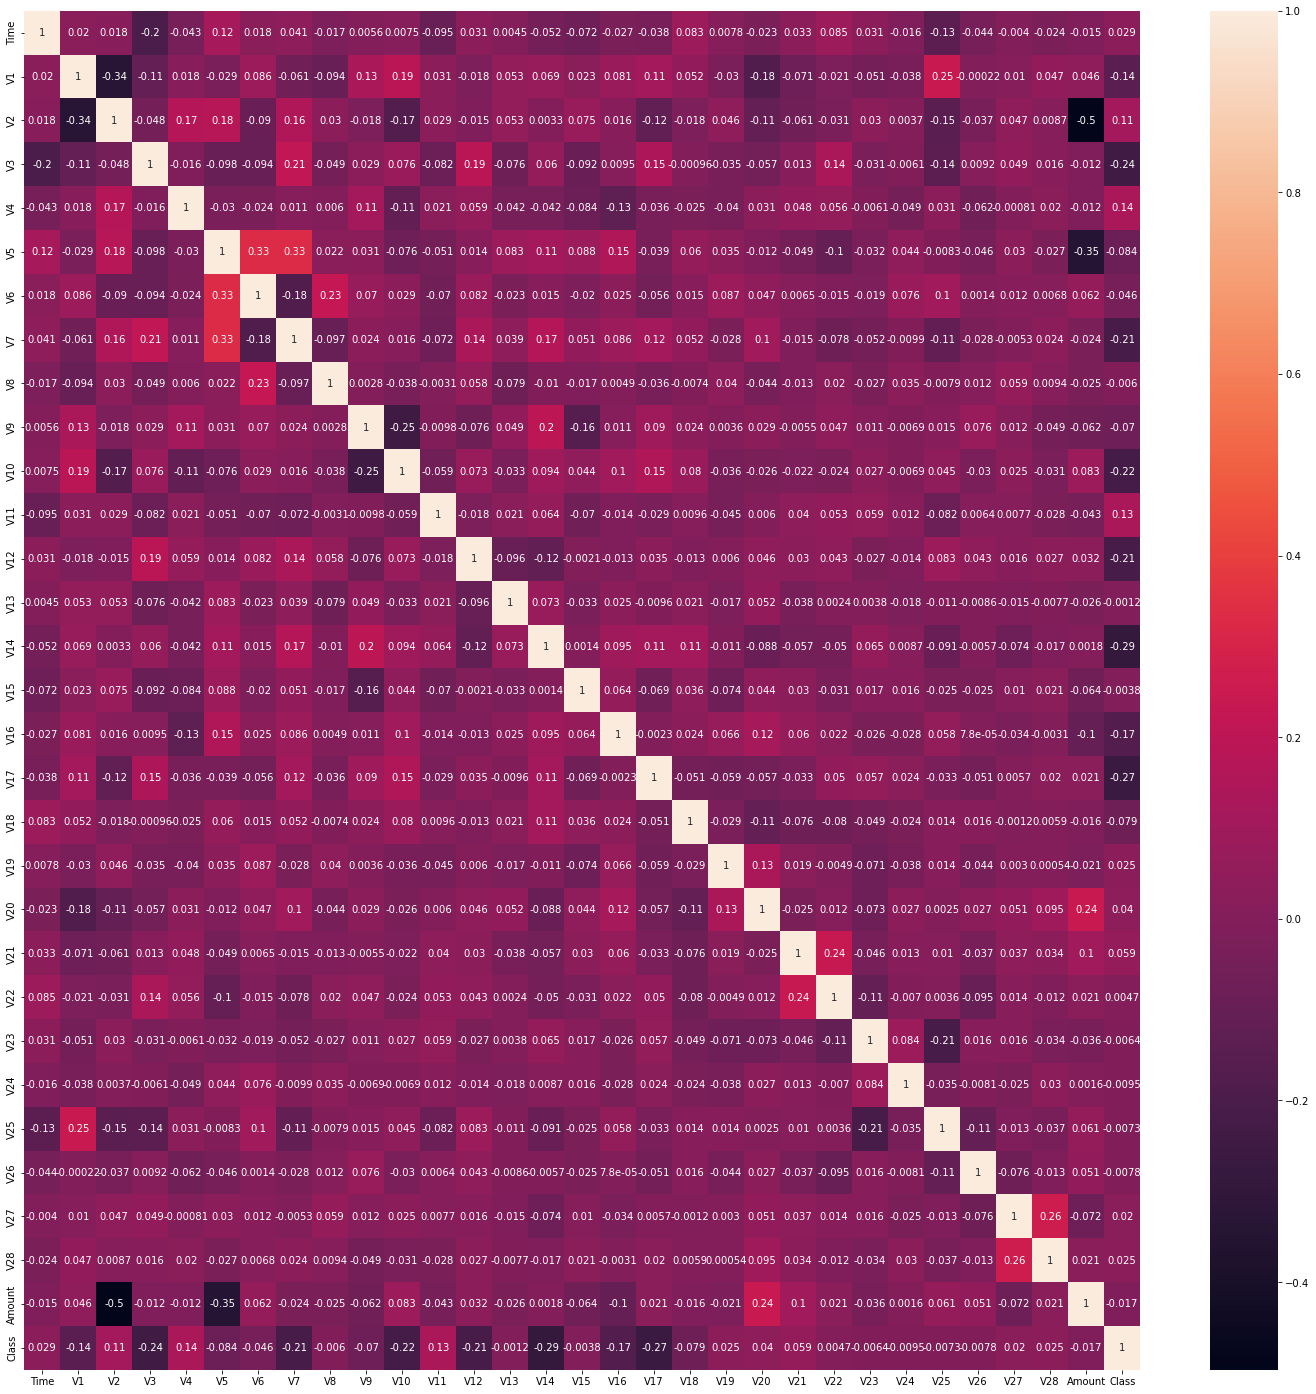

In [10]:
plt.figure(figsize=(25,25))
sns.heatmap(train.corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

In [11]:
FEATURES.remove("Time")
train.drop(["Time" ] , axis = 1 ,inplace = True)
test.drop(["Time"] , axis = 1 ,inplace = True)
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

In [12]:
FOLDS = 5

In [13]:
from sklearn.model_selection import StratifiedKFold

Since this is a fraud detection we can't depend on accuracy metric .. my evaluation metric will be **AUC** (area under curve) with 5 folds 
i'm going to take the mean .

In [14]:
catb_params = {
    "objective": "Logloss",
    "iterations": 1000,
    'l2_leaf_reg': 2.8,
    "eval_metric": "AUC",
    "random_seed": 12,
    "task_type": "GPU"
}


catb_predictions = 0
catb_scores = []
catb_fimp = []

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[FEATURES], train[TARGET])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][FEATURES], train.iloc[valid_idx][FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]
    model = CatBoostClassifier(**catb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  preds_valid)
    catb_scores.append(auc)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, AUC score: {auc:.2f}, Run Time: {run_time:.2f}s")
    fim = pd.DataFrame(index=FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    catb_fimp.append(fim)
    test_preds = model.predict_proba(test[FEATURES])[:, 1]
    catb_predictions += test_preds/FOLDS
    
print("Mean AUC :", np.mean(catb_scores))

========== Fold=1 ==========


Default metric period is 5 because AUC is/are not implemented for GPU


Fold=1, AUC score: 0.92, Run Time: 47.59s
========== Fold=2 ==========


Default metric period is 5 because AUC is/are not implemented for GPU


Fold=2, AUC score: 0.89, Run Time: 44.52s
========== Fold=3 ==========


Default metric period is 5 because AUC is/are not implemented for GPU


Fold=3, AUC score: 0.90, Run Time: 40.38s
========== Fold=4 ==========


Default metric period is 5 because AUC is/are not implemented for GPU


Fold=4, AUC score: 0.90, Run Time: 41.70s
========== Fold=5 ==========


Default metric period is 5 because AUC is/are not implemented for GPU


Fold=5, AUC score: 0.91, Run Time: 42.93s
Mean AUC : 0.9037934710557252


In [15]:
def preds_plot(preds):
    plt.figure(figsize=(15, 7))
    plt.title('Distribution of predictions', 
          size=25, y=1.03, fontname='Calibri', 
          fontweight='bold', color='#444444')
    a = sns.histplot(preds, color='#72bfd6', bins=100)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)
    plt.show()


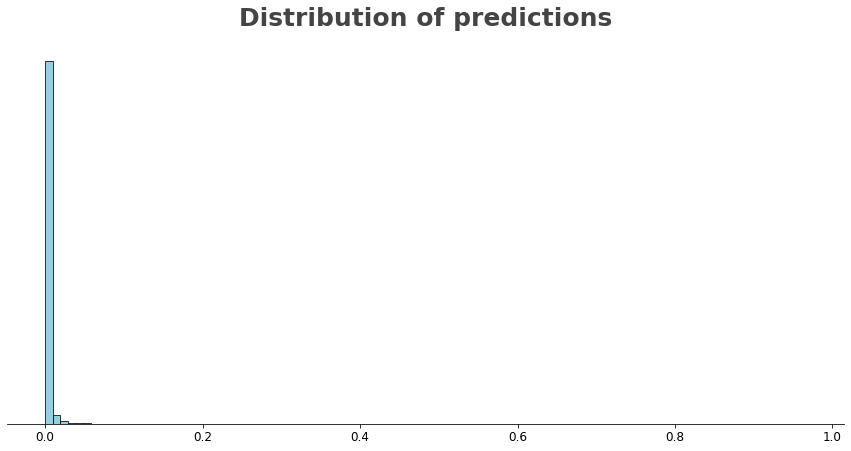

In [16]:
preds_plot(catb_predictions)

In [17]:
ss['Class']=catb_predictions

In [18]:
ss

,id,Class
0,219129,0.005196
1,219130,0.001061
2,219131,0.000487
3,219132,0.003518
4,219133,0.001360
...,...,...
146082,365211,0.000631
146083,365212,0.001626
146084,365213,0.001049
146085,365214,0.000584


In [19]:
ss.to_csv('submission.csv', index=False)